# RL homework 4

-------------------------------


**Name:** John Goodacre

**SN:** 13064947

-----------------------------------


**Start date:** *29th March 2018*

**Due date:** *19th April 2018, 4:55 pm*

------------------------------------

## How to Submit

When you have completed the exercises and everything has finsihed running, click on 'File' in the menu-bar and then 'Download .ipynb'. This file must be submitted to Moodle named as **studentnumber_RL_hw4.ipynb** before the deadline above.

Also send a **sharable link** to the notebook at the following email: ucl.coursework.submit@gmail.com. You can also make it sharable via link to everyone, up to you.

Please compile all results and all answers to the understanding questions into a PDF. Name convention: **studentnumber_RL_hw4.pdf**. Do not include any of the code (we will use the notebook for that). 

**Page limit: 10 pg **


## Context

In this assignment, we will take a first look at learning decisions from data.  For this, we will use the multi-armed bandit framework.

## Background reading

* Sutton and Barto (2018), Chapters 6-7 + 9-11

# Setup

### Import Useful Libraries

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from collections import namedtuple
%matplotlib inline

### Set options

In [0]:
np.set_printoptions(precision=3, suppress=1)

### Helper functions

In [0]:
def run_experiment(env, agent, number_of_steps):
    mean_reward = 0.
    try:
      action = agent.initial_action()
    except AttributeError:
      action = 0
    for i in range(number_of_steps):
      reward, discount, next_state = grid.step(action)
      action = agent.step(reward, discount, next_state)
      mean_reward += (reward - mean_reward)/(i + 1.)

    return mean_reward

map_from_action_to_subplot = lambda a: (2, 6, 8, 4)[a]
map_from_action_to_name = lambda a: ("up", "right", "down", "left")[a]

def plot_values(values, colormap='pink', vmin=None, vmax=None):
  plt.imshow(values, interpolation="nearest", cmap=colormap, vmin=vmin, vmax=vmax)
  
  plt.yticks([])
  plt.xticks([])
  plt.colorbar(ticks=[vmin, vmax])

def plot_action_values(action_values, vmin=None, vmax=None):
  q = action_values
  fig = plt.figure(figsize=(8, 8))
  fig.subplots_adjust(wspace=0.3, hspace=0.3)
  for a in [0, 1, 2, 3]:
    plt.subplot(3, 3, map_from_action_to_subplot(a))
    plot_values(q[..., a], vmin=vmin, vmax=vmax)
    action_name = map_from_action_to_name(a)
    plt.title(r"$q(s, \mathrm{" + action_name + r"})$")
    
  plt.subplot(3, 3, 5)
  v = 0.9 * np.max(q, axis=-1) + 0.1 * np.mean(q, axis=-1)
  plot_values(v, colormap='summer', vmin=vmin, vmax=vmax)
  plt.title("$v(s)$")


def plot_rewards(xs, rewards, color):
  mean = np.mean(rewards, axis=0)
  p90 = np.percentile(rewards, 90, axis=0)
  p10 = np.percentile(rewards, 10, axis=0)
  plt.plot(xs, mean, color=color, alpha=0.6)
  plt.fill_between(xs, p90, p10, color=color, alpha=0.3)
  

def parameter_study(parameter_values, parameter_name,
  agent_constructor, env_constructor, color, repetitions=10, number_of_steps=int(1e4)):
  mean_rewards = np.zeros((repetitions, len(parameter_values)))
  greedy_rewards = np.zeros((repetitions, len(parameter_values)))
  for rep in range(repetitions):
    for i, p in enumerate(parameter_values):
      env = env_constructor()
      agent = agent_constructor()
      if 'eps' in parameter_name:
        agent.set_epsilon(p)
      elif 'alpha' in parameter_name:
        agent._step_size = p
      else:
        raise NameError("Unknown parameter_name: {}".format(parameter_name))
      mean_rewards[rep, i] = run_experiment(grid, agent, number_of_steps)
      agent.set_epsilon(0.)
      agent._step_size = 0.
      greedy_rewards[rep, i] = run_experiment(grid, agent, number_of_steps//10)
      del env
      del agent

  plt.subplot(1, 2, 1)
  plot_rewards(parameter_values, mean_rewards, color)
  plt.yticks=([0, 1], [0, 1])
  # plt.ylim((0, 1.5))
  plt.ylabel("Average reward over first {} steps".format(number_of_steps), size=12)
  plt.xlabel(parameter_name, size=12)

  plt.subplot(1, 2, 2)
  plot_rewards(parameter_values, greedy_rewards, color)
  plt.yticks=([0, 1], [0, 1])
  # plt.ylim((0, 1.5))
  plt.ylabel("Final rewards, with greedy policy".format(number_of_steps), size=12)
  plt.xlabel(parameter_name, size=12)
  
def epsilon_greedy(q_values, epsilon):
  if epsilon < np.random.random():
    return np.argmax(q_values)
  else:
    return np.random.randint(np.array(q_values).shape[-1])

### A small MRP

In [0]:
class SmallMRP(object):

  def __init__(self, p=0.1):
    self._state = 0
    self._p = p

  def get_state(self):
    return self._state

  def step(self):
    reward = 0
    discount = 1
    if self._state == 0:
      self._state = 1
    else:
      if np.random.random() < self._p:
        self._state = 0
        discount = 0
      else:
        self._state = 1

    return reward, discount, self.get_obs()

## Assignment 1 [50pts in total] ALL ANSWERS GIVEN IN THE ASSOCIATED PDF FILE - AS WELL AS THE ADDITIONAL PLAYGROUND.IPYNB FOR THE MRP

We are going to analyze the simple Markov reward process (MRP - a MRP is an MDP without actions or, equivalently, with a single action in each state) defined in the code cell above.  It consists of two states.  The reward is zero everywhere.  When we are in state $s_0$, we always transition to $s_1$.  If we are in state $s_1$, there is a probability $p$ (which is set to 0.1 by default in the code above) of terminating, after which the next episode starts in $s_0$ again.  With a probability of $1 - p$, we transition from $s_1$ back to itself again.  The discount is $\gamma = 1$ on non-terminal steps.

#### [1pt] Question 1.1
What is the optimal value in each state?

_answer here_

#### [1pt] Question 1.2
Instead of a tabular representation, consider a single feature $\phi$, which takes the values $\phi(s_0) = 1$ and $\phi(s_1) = 4$.  Now consider using linear function approximation, where we learn a value $\theta$ such that $v_{\theta}(s) = \theta \times \phi(s) \approx v(s)$, where $v(s)$ is the true value of state $s$.  What is the optimal value of $\theta$?

_answer here_

#### [8pts] Question 1.3
Suppose $\theta_0 = 1$, and suppose we update this parameter with TD(0) with a step size of $\alpha = 0.1$.  What is the expected value of $\mathbb{E}[ \theta_T ]$ if we step through the MDP until it terminates after the first episode, as a function of $p$?  (Note that $T$ is random.)

_answer here_

#### [5pts] Question 1.3
If $p=0.1$, how many episodes does it take, starting from $\theta_0 = 1$, until $| v(s) - \mathbb{E}[v_{\theta}(s)] | < 0.5$ for all $s$, where the expectation is over the expected updates to $\theta$?

_answer here_

#### Synchronous updates
Consider the following algorithm: we use TD to update the parameters, but instead of using the online data, we assume we can actively sample a transition from both states.  We then update $\theta$ using both samples:
$$
\theta_{n+1} = \theta_n + \alpha \delta_0 \phi(s_0) + \alpha \delta_1 \phi(s_1) \,,
$$
where $\delta_i$ is a sampled one-step TD error when transitioning from state $s_i$.

#### [10pts] Question 1.4

What is the value of $\mathbb{E}[\theta_n]$, as a function of $n$ and $p$?

_answer here_

#### [5pts] Question 1.5

For which values of $p$ does not $\theta$ converge to the optimal solution?

_answer here_

#### [10pts] Question 1.5
Why doesn't it?  TD is known to converge, with linear function approximation, under certain assumptions.  Explain for this concrete case why the algorithm does not converge, and explain which general assumption is violated that would otherwise ensure convergence of linear TD (in at most 200 words).

_answer here_

#### [10pts] Question 1.5
Describe a way to change the algorithm to obtain convergence of $\theta$, for any $p$, without changing the sampling or the value function (which should remain as $v_{\theta}(s) = \theta \times \phi(s)$).  Note that the sampling is not sequential, so for instance you cannot add memory of previous states.  (At most 200 words.)

_answer here_



## Assignment 2 [50pts in total + 10 BONUS pts]

### A grid world

In [0]:
class Grid(object):

  def __init__(self, tabular=True, vision_size=1, noisy=False):
    # -1: wall
    # 0: empty, episode continues
    # other: number indicates reward, episode will terminate
    self._layout = np.array([
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
      [-1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1],
      [-1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1],
      [-1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1],
      [-1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1],
      [-1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1],
      [-1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1],
      [-1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1],
      [-1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1],
      [-1, -1, -1, -5, -1, -1, -1, -1, -6, -1, -1, -1, -1, 10, -1, -1, -1],
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    ])
    self._start_state = (3, 2)
    self._state = self._start_state
    self._number_of_states = np.prod(np.shape(self._layout))
    self._noisy = noisy
    self._tabular = tabular
    self._vision_size = vision_size

  @property
  def number_of_states(self):
      return self._number_of_states
    
  def plot_grid(self):
    plt.figure(figsize=(4, 4))
    #plt.imshow(self._layout != -1, interpolation="nearest")
    plt.imshow(self._layout != -1, interpolation="nearest", cmap='pink')
    ax = plt.gca()
    ax.grid(0)
    plt.xticks([])
    plt.yticks([])
    plt.title("The grid")
    plt.text(2, 2, r"$\mathbf{S}$", ha='center', va='center')
    goal_y, goal_x = np.where(self._layout==10)
    plt.text(goal_x, goal_y, r"$\mathbf{G}$", ha='center', va='center')
    goal_y, goal_x = np.where(self._layout==-5)
    plt.text(goal_x, goal_y, r"$\mathbf{D}$", ha='center', va='center')
    goal_y, goal_x = np.where(self._layout==-6)
    plt.text(goal_x, goal_y, r"$\mathbf{D}$", ha='center', va='center')
    h, w = self._layout.shape
    for y in range(h-1):
      plt.plot([-0.5, w-0.5], [y+0.5, y+0.5], '-k', lw=2)
    for x in range(w-1):
      plt.plot([x+0.5, x+0.5], [-0.5, h-0.5], '-k', lw=2)

  def get_obs(self):
    y, x = self._state
    return self.get_obs_at(x, y)

  def get_obs_at(self, x, y):
    if self._tabular:
      return y*self._layout.shape[1] + x
    else:
      v = self._vision_size
      location = np.clip(-self._layout[y-v:y+v+1,x-v:x+v+1], 0, 1)
      return location

  def step(self, action):
    y, x = self._state
    
    if action == 0:  # up
      new_state = (y - 1, x)
    elif action == 1:  # right
      new_state = (y, x + 1)
    elif action == 2:  # down
      new_state = (y + 1, x)
    elif action == 3:  # left
      new_state = (y, x - 1)
    else:
      raise ValueError("Invalid action: {} is not 0, 1, 2, or 3.".format(action))

    new_y, new_x = new_state
    discount = 0.98
    if self._layout[new_y, new_x] == -1:  # wall
      reward = -1
      new_state = (y, x)
    elif self._layout[new_y, new_x] != 0: # a goal
      reward = self._layout[new_y, new_x]
      discount = 0.
      new_state = self._start_state
    else:
      reward = (new_y + new_x) / np.sum(self._layout.shape)
    if self._noisy:
      width = self._layout.shape[1]
      reward += 2*np.random.normal(0, width - new_x + new_y)
    
    self._state = new_state

    return reward, discount, self.get_obs()
    

### The grid

The cell below shows the `Grid` environment that we will use. Here `S` indicates the start state and `G` indicates the goal.  The agent has four possible actions: up, right, down, and left.  Rewards are: `-1` for bumping into a wall, `+10` for reaching the goal, and `(x + y)/(height + width)` otherwise, which encourages the agent to go right and down.  The episode ends when the agent reaches the goal.  At the end of the left-most two corridors, there are distractor 'goals' (marked `D`) that give a reward of $-5$ and $-6$, and then also terminate the episode.  The discount, on continuing steps, is $\gamma = 0.98$.  Feel free to reference the implemetation of the `Grid` above, under the header "a grid world".

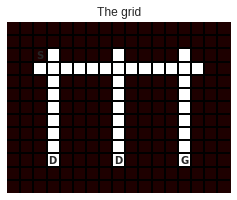

In [9]:
grid = Grid()
grid.plot_grid()


## Implement agents
**[10 pts]** In the next code cell, implement an agent that uses **tabular Sarsa** to learn action values.  The agent should act according to an $\epsilon$-greedy policy with respect to its action values.

The agent will be initialized with:
```
agent = Sarsa(number_of_states=grid._layout.size,
              number_of_actions=4,
              grid.get_obs())
```

In [0]:
class Sarsa(object):
  """Implementation of tabular Sarsa"""
  
  def __init__(self, number_of_states, number_of_actions, initial_state, step_size=0.1):
    self._q = np.zeros((number_of_states, number_of_actions)) #q values (state, action)
    self._s = initial_state
    self._number_of_actions = number_of_actions
    self._step_size = step_size
    self._last_action = 0 
    
    #make up an epsilon
    self._eps = 0.1
    
  @property
  def q_values(self):
    # This function should return the action values for all states and actions
    # in a numpy array of shape (number_of_states, number_of_actions)
    return self._q

  def step(self, r, g, s):
    # This function should return an action
    a_old = self._last_action #retrieve last state and action
    s_old = self._s
    
    #choose a next action according to epsilon greedy
    explore = bool(np.random.random() < self._eps)
    if explore:
        a_next = np.random.randint(self._number_of_actions)
    else:
        a_next = np.argmax(self._q[s,:])
        
    #update q values - sarsa so just using next state and epsilon greedy action
    self._q[s_old,a_old] = self._q[s_old,a_old] + self._step_size* \
                        (r + g*self._q[s, a_next] - self._q[s_old,a_old])
       
    #update state and action
    self._s = s
    self._last_action = a_next
    return self._last_action    

**[20 pts]** Implement an agent that uses **neural Sarsa** to learn action values.  The agent should expect a nxn input which it should flatten into a vector, and then pass through a multi-layer perceptron with a single hidden layer with 100 hidden nodes and ReLU activations.  Each weight layer should also have a bias.  Initialize all weights uniformly randomly in $[-0.05, 0.05]$.

```
NeuralSarsa(number_of_features=(2*vision_size + 1)**2,
            number_of_hidden=100,
            number_of_actions=4,
            initial_state=grid.get_obs(),
            step_size=0.01)
```

The number `vision_size` will be either 1 or 2 below.  The input vector will be of size $(2v + 1)^2$, which will correspond to a square local view of the grid, centered on the agent, and of size $(2v + 1) \times (2v + 1)$ (so either 3x3 or 5x5).

You are allowed, but not mandated, to use TensorFlow to implement this agent.  (The network is small enough that you can also use numpy, but then you have to implement your own backprop.)  Please document the code clearly, especially on non-trivial operations.

In [0]:
import tensorflow as tf

class NeuralSarsa(object):
  """Various things in here - Neural Sarsa - Also tried a Neural Q - by replacing the
  epsilon greedy with max over next actions
  
  Tensorflow multi-layer perceptron - also tried adding experience replays...
  Plus variations on the experience replays -- random / happy/ sad ! The idea being 
  if there was a high reward or very negative to replay these more often...this was
  really to achieve better convergence but also to see the effects on greedy actions 
  and q values"""
  
  def __init__(self, number_of_features, number_of_hidden, number_of_actions, initial_state, step_size=0.01):
    self.number_of_features = number_of_features
    self.number_of_hidden = number_of_hidden
    self.number_of_actions = number_of_actions
    self._s = initial_state
    self._step_size = step_size
    
    self._last_action = 0
    self._eps = 0.1
    
    #Experience replay will story a buffer of experiences and replay to update the q values
    #as well as the online learning bit
    self._num_offline_updates = 0
    self._num_happyoffline_updates = 7
    self._num_sadoffline_updates = 0
    self._replay = []
    self._happyreplay = []
    self._sadreplay = []
    
    tf.reset_default_graph()
    
    self.x = tf.placeholder(tf.float32, [None, number_of_features])
    
    #Set up the MLP with relu activations 
    W1 = tf.Variable(tf.random_uniform([number_of_features, number_of_hidden],-0.05,0.05))
    b1 = tf.Variable(tf.random_uniform([number_of_hidden],-0.05,0.05))
    W2 = tf.Variable(tf.random_uniform([number_of_hidden, number_of_actions],-0.05,0.05))
    b2 = tf.Variable(tf.random_uniform([number_of_actions],-0.05,0.05))
    
    h1 = tf.nn.relu(tf.matmul(self.x, W1) + b1)
    #our predicted action values
    self.qvals = tf.matmul(h1,W2)+b2
    
    #Put in the nextQ value calculated dynamically in a step and passed in as a target
    self.nextQ = tf.placeholder(tf.float32, [None, number_of_actions])
    self.loss = tf.reduce_sum(tf.square(self.nextQ - self.qvals))
    
    self.update_model = tf.train.AdagradOptimizer(step_size).minimize(self.loss)
    
    self.sess = tf.Session()
    self.sess.run(tf.initialize_all_variables())
    
  def q(self, obs):
    # This function should give the vector of action values for observation obs
    #state_obs = obs.flatten()
    
    #return the action values for obs
    state_obs = obs.reshape(1,self.number_of_features)
    return self.sess.run(self.qvals, feed_dict={self.x:state_obs})[0]
  
  def step(self, r, g, s):
    # This function should return an action
    a_old = self._last_action
    s_old = self._s
    
    old_qvals = self.q(s_old) #retrieve q values for last state
    next_qvals = self.q(s) #retrieve predicted q values for the next state

    #choose a next action according to epsilon greedy
    explore = bool(np.random.random() < self._eps)
    if explore:
      a_next = np.random.randint(self.number_of_actions)
    else:
      a_next = np.argmax(next_qvals)
      
    #Use this if we are doing sarsa and max if we are doing neural q
    #Q1 = next_qvals[a_next]
    Q1 = np.max(next_qvals)
    targetQ = next_qvals
    targetQ[a_old] = r + g*Q1 #update the new target
     
    #update the model
    _,pred_qvals = self.sess.run([self.update_model,self.qvals],feed_dict={self.x:s_old.reshape(1,self.number_of_features)
                                                          ,self.nextQ:targetQ.reshape(1,self.number_of_actions)})
    
    
    #add experience to replay buffer
    self._replay.append((s_old,a_old,r,g,s))
    
    #Repay memories from the buffer to update our q values more times
    for i in range(self._num_offline_updates):
        
      #uniform sampling
      ind = np.random.randint(0,len(self._replay))
      srep,arep,rrep,grep,next_srep = self._replay[ind]
      
      a_old_rep = arep
      s_old_rep = srep
    
      next_qvalsrep = self.q(next_srep)

      #choose a next action according to epsilon greedy
      explore = bool(np.random.random() < self._eps)
      if explore:
        a_nextrep = np.random.randint(self.number_of_actions)
      else:
        a_nextrep = np.argmax(next_qvalsrep)
    
      #Q1rep = next_qvalsrep[a_nextrep]
      Q1rep = np.max(next_qvalsrep)
      targetQrep = next_qvalsrep
      targetQrep[a_old_rep] = rrep + grep*Q1rep
     
      _,model_loss = self.sess.run([self.update_model,self.loss],feed_dict={self.x:s_old_rep.reshape(1,self.number_of_features)
                                                          ,self.nextQ:targetQrep.reshape(1,self.number_of_actions)})
    
    #I found that the agent found the goal only a few times, this introduces more experience
    #replays when there are positive rewards.
    
    if r>0:
      #add experience to replay buffer
      self._happyreplay.append((s_old,a_old,r,g,s))
      
        #Repay memories from the buffer to update our q values more times
      for i in range(self._num_happyoffline_updates):

        #uniform sampling
        ind = np.random.randint(0,len(self._happyreplay))
        srep,arep,rrep,grep,next_srep = self._happyreplay[ind]

        a_old_rep = arep
        s_old_rep = srep

        next_qvalsrep = self.q(next_srep)

        #choose a next action according to epsilon greedy
        explore = bool(np.random.random() < self._eps)
        if explore:
          a_nextrep = np.random.randint(self.number_of_actions)
        else:
          a_nextrep = np.argmax(next_qvalsrep)

        #Q1rep = next_qvalsrep[a_nextrep]
        Q1rep = np.max(next_qvalsrep)
        targetQrep = next_qvalsrep
        targetQrep[a_old_rep] = rrep + grep*Q1rep

        _,model_loss = self.sess.run([self.update_model,self.loss],feed_dict={self.x:s_old_rep.reshape(1,self.number_of_features)
                                                            ,self.nextQ:targetQrep.reshape(1,self.number_of_actions)})
        
    #This is just a test and didn't prove very helpful. I found if the agent had too many positive
    #experience replays it would want to go down the first two 'bad tunnels' and return...by also replaying 
    #very bad experiences I hoped to reverse this...however alas it didn't really help.
    if r<-2:
      #add experience to replay buffer
      self._sadreplay.append((s_old,a_old,r,g,s))
      
        #Repay memories from the buffer to update our q values more times
      for i in range(self._num_sadoffline_updates):

        #uniform sampling
        ind = np.random.randint(0,len(self._sadreplay))
        srep,arep,rrep,grep,next_srep = self._sadreplay[ind]

        a_old_rep = arep
        s_old_rep = srep

        next_qvalsrep = self.q(next_srep)

        #choose a next action according to epsilon greedy
        explore = bool(np.random.random() < self._eps)
        if explore:
          a_nextrep = np.random.randint(self.number_of_actions)
        else:
          a_nextrep = np.argmax(next_qvalsrep)

        #Q1rep = next_qvalsrep[a_nextrep]
        Q1rep = np.max(next_qvalsrep)
        targetQrep = next_qvalsrep
        targetQrep[a_old_rep] = rrep + grep*Q1rep

        _,model_loss = self.sess.run([self.update_model,self.loss],feed_dict={self.x:s_old_rep.reshape(1,self.number_of_features)
                                                            ,self.nextQ:targetQrep.reshape(1,self.number_of_actions)})
    
    #update state and action
    
    self._s = s
    self._last_action = a_next
    return self._last_action
  
  

# Analyse Results

### Run the cells below to train the tabular and neural SARSA agents and to generate plots.

This trains the agents the Grid problem with an epsilon of 0.1.

The plots below will show action values for each of the actions, as well as a state value defined by $v(s) = \sum_a \pi(a|s) q(s, a)$.

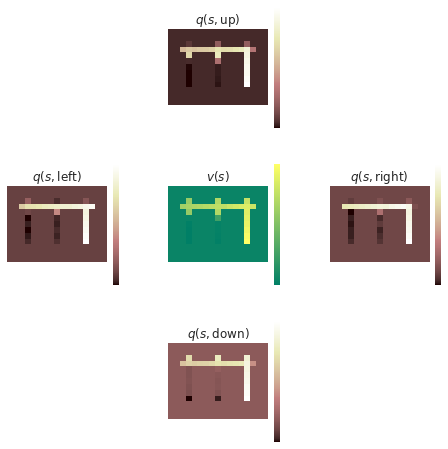

In [67]:
grid = Grid()
number_of_actions = 4
number_of_states=grid._layout.size
agent = Sarsa(number_of_states,
              number_of_actions,
              grid.get_obs())

run_experiment(grid, agent, int(1e5))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)

In [0]:
def plot_greedy_policy(grid, q):
  action_names = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"]
  greedy_actions = np.argmax(q, axis=2)
  grid.plot_grid()
  plt.hold('on')
  for i in range(12):
    for j in range(16):
      action_name = action_names[greedy_actions[i,j]]
      plt.text(j, i, action_name, ha='center', va='center')

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  """


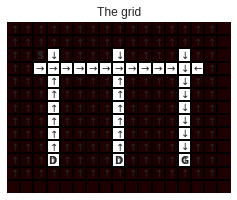

In [69]:
plot_greedy_policy(grid,q)

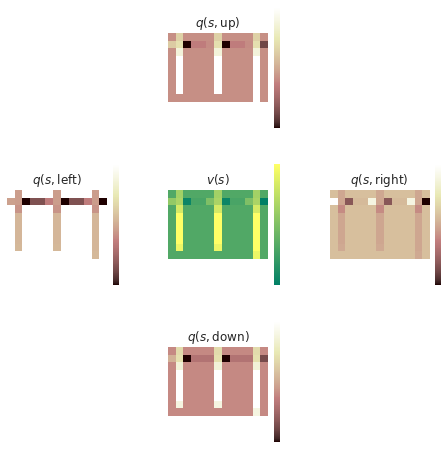

In [70]:
vision_size = 1
grid = Grid(tabular=False, vision_size=vision_size)
agent = NeuralSarsa(number_of_features=(2*vision_size + 1)**2,
                    number_of_hidden=100,
                    number_of_actions=4,
                    initial_state=grid.get_obs(),
                    step_size=0.01)
run_experiment(grid, agent, int(1e5))
h, w = grid._layout.shape
obs = np.array([[grid.get_obs_at(x, y) for x in range(2, w-2)] for y in range(2, h-2)])
qs = np.array([[[agent.q(o)[a] for a in range(4)] if o[vision_size,vision_size] == 0 else np.zeros((4,)) for o in ob] for ob in obs])
plot_action_values(qs)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  # This is added back by InteractiveShellApp.init_path()


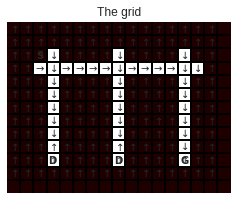

In [71]:
"""The existing code doesn't plot the greedy actions for the neural sarsa which
I wanted in the pdf...this is a quick hack to get greedy graphs for the neural sarsa"""

def plot_greedy_policy(grid, q):
  action_names = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"]
  greedy_actions = np.argmax(q, axis=2)
  
  #this is ugly beyond belief but just to get a greedy diagram lol
  greedy_actions = np.vstack([np.vstack([np.zeros((2,17)),np.hstack([np.hstack([np.zeros((9,2)),
                                                                                np.argmax(q,2)]),np.zeros((9,2))])]) , np.zeros((2,17))])
  greedy_actions = greedy_actions.astype(int)
  grid.plot_grid()
  plt.hold('on')
  for i in range(12):
    for j in range(16):
      action_name = action_names[greedy_actions[i,j]]
      plt.text(j, i, action_name, ha='center', va='center')
plot_greedy_policy(grid,qs)

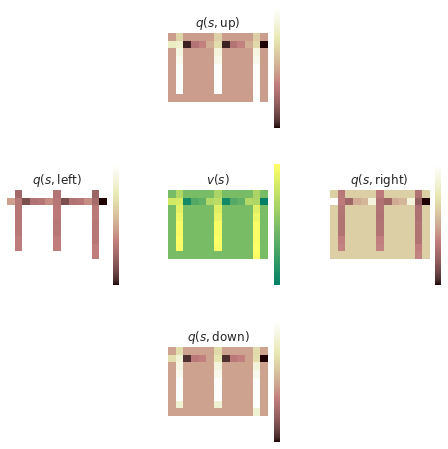

In [72]:
vision_size = 2
grid = Grid(tabular=False, vision_size=vision_size)
agent = NeuralSarsa(number_of_features=(2*vision_size + 1)**2,
                    number_of_hidden=100,
                    number_of_actions=4,
                    initial_state=grid.get_obs(),
                    step_size=0.01)
run_experiment(grid, agent, int(1e5))
h, w = grid._layout.shape
obs = np.array([[grid.get_obs_at(x, y) for x in range(2, w-2)] for y in range(2, h-2)])
qs = np.array([[[agent.q(o)[a] for a in range(4)] if o[vision_size,vision_size] == 0 else np.zeros((4,)) for o in ob] for ob in obs])
plot_action_values(qs)


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  # This is added back by InteractiveShellApp.init_path()


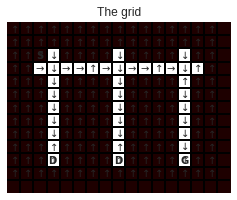

In [73]:
plot_greedy_policy(grid,qs)

## Questions - All questions are answered in the pdf document.

Consider the greedy policy with respect to the estimated values

**[5 pts]** Which algorithm performed best?  Why?

**[5 pts]** Is there a difference in the solution found by Neural Sarsa with a vision size of 1 (so 3x3 local observations), and a vision size of 2 (so 5x5 local observations)?  Why?

**[10 pts]** How could we improve the performance of the Neural Sarsa agent on this domain (for both vision sizes)?  Identify the main issue, and propose a concrete solution (in max 200 words).

**[10 BONUS pts]** Implement your proposed improvement and show that it actually helps performance.